# Data Retrieval

In [6]:
import pandas as pd
import numpy as np
import sklearn
import os

In [7]:
# directories for csv files
csv_dir = 'C:/Users/micha/OneDrive - UT Health San Antonio/UTHSCSA/Trauma/TransfusionPrediction/data/PUF AY 2022/CSV'
os.listdir(csv_dir)

['PUF Variable Formats.csv',
 'PUF_AIS15TO05_CROSSWALK.csv',
 'PUF_AISDIAGNOSIS.csv',
 'PUF_AISDIAGNOSIS_LOOKUP.csv',
 'PUF_Ecode_Lookup.csv',
 'PUF_HOSPITALEVENTS.csv',
 'PUF_ICDDIAGNOSIS.csv',
 'PUF_ICDDIAGNOSIS_LOOKUP.csv',
 'PUF_ICDPROCEDURE.csv',
 'PUF_ICDPROCEDURE_LOOKUP.csv',
 'PUF_PREEXISTINGCONDITIONS.csv',
 'PUF_TRAUMA.csv',
 'PUF_TRAUMA_LOOKUP.csv',
 'TQP_INCLUSION.csv']

In [8]:
# create a pandas dataframe for each file

os.listdir(csv_dir)

directory = csv_dir
# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Remove the first 4 characters, replace spaces with underscores, and create a dataframe name
        df_name = filename[4:].lower().replace('.csv', '').replace(' ', '_')
        
        # Try different encodings and handle spaces
        try:
            df = pd.read_csv(os.path.join(directory, filename), encoding='utf-8', skipinitialspace=True)
        except UnicodeDecodeError:
            df = pd.read_csv(os.path.join(directory, filename), encoding='latin1', skipinitialspace=True)
        
        # Assign the dataframe to a variable with the processed name
        globals()[df_name] = df

        print(f"Created dataframe: {df_name}")





Created dataframe: variable_formats
Created dataframe: ais15to05_crosswalk
Created dataframe: aisdiagnosis
Created dataframe: aisdiagnosis_lookup
Created dataframe: ecode_lookup
Created dataframe: hospitalevents
Created dataframe: icddiagnosis
Created dataframe: icddiagnosis_lookup
Created dataframe: icdprocedure
Created dataframe: icdprocedure_lookup
Created dataframe: preexistingconditions


C:\Users\micha\AppData\Local\Temp\ipykernel_27596\1041542712.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(directory, filename), encoding='utf-8', skipinitialspace=True)


Created dataframe: trauma
Created dataframe: trauma_lookup
Created dataframe: inclusion


The dataset we will be using is 'trauma', so we will select that file.

In [9]:
# will be using the trauma part
trauma.shape
# 231 different predictors; will need to determine which ones are not available to a physician, and then get rid of those
# then separate what we need as response variables

(1232956, 231)

We need to create a response variable, so we will create the variable transfusion. This will be a Yes or No for whether the patient recieved a transfusion, of any kind.

In [10]:
# transfusions, which ICD procedure code starts with 302:
transfusions = icdprocedure[icdprocedure['ICDPROCEDURECODE'].str.startswith('302') & icdprocedure['ICDPROCEDURECODE'].notnull()]

print(transfusions.shape)
# 200411 transfusions in this dataset

(200411, 6)


In [11]:

# Find the number of unique values in the first column 'inc_key'
unique_keys = trauma['inc_key'].nunique()

# Display the result
print(f'The number of unique values in the first column "inc_key" is: {unique_keys}')
# each one is a unique key

print(trauma.SBP_BIU.dropna())

The number of unique values in the first column "inc_key" is: 1232956
6          2.0
7          2.0
9          2.0
11         2.0
13         2.0
          ... 
1232687    2.0
1232694    2.0
1232753    2.0
1232833    2.0
1232874    2.0
Name: SBP_BIU, Length: 54597, dtype: float64


Some of these variables are not available when presenting to the hospital (such as discharge date) and will thus not be available to the physician. These will be removed.

In [12]:
print("Column names in the 'trauma' DataFrame:")
# print(trauma.columns.tolist())
# not in the same order as the user manual. will need to go through each of these manually :'(


cols_to_remove =[
    'EDDISCHARGEDISPOSITION','EDDISCHARGEDISPOSITION_BIU','FINALDISCHARGEDH_BIU','FINALDISCHARGEHRS','FINALDISCHARGEDAYS','HOSPDISCHARGEDISPOSITION','HOSPDISCHARGEDISPOSITION_BIU',
    'WITHDRAWALLSTDAYS','WITHDRAWALLSTHRS','WITHDRAWALLSTDH_BIU','WITHDRAWALLST','WITHDRAWALLST_BIU','INPATIENTDAYS','INPATIENTHRS','INPATIENTDH_BIU',
    'TOTALICULOS','TOTALICULOS_BIU','EDDISCHARGEDAYS','EDDISCHARGEHRS','EDDISCHARGEDH_BIU',
# left off at page 26. seems procedures are next, so decide about that
]

cols_to_remove_retired = [
    'LOSDAYS','LOSMINS' # LOSDAYS and LOSMINS are retired after 2018, replaced by final discharge days and hrs
    'WITHDRAWALLSTMINS', # 2018
    'HOSPITALDISCHARGEDAYS','HOSPITALDISCHARGEHRS','HOSPITALDISCHARGEDH_BIU', # 2019
    'EDDAYS','EDMINS', # 2018
    'YODISCH', # 2018
]

# hospital complications appear to be retired, and in another dataset
hospital_complications = [
    'HC_KIDNEY', 'HC_RESPIRATORY','HC_ALCOHOLWITHDRAWAL','HC_CARDARREST','HC_CAUTI','HC_CLABSI','HC_DEEPSSI', 'HC_DVTHROMBOSIS','HC_EXTREMITYCS', 'HC_MI', 
    'HC_NA', 'HC_UK', 'HC_ORGANSPACESSI', 'HC_OSTEOMYELITIS','HC_OTHER','HC_PRESSUREULCER', 'HC_EMBOLISM', 'HC_SEPSIS','HC_STROKECVA','HC_SUPERFICIALINCISIONSSI','HC_UNPLANNEDICU',
    'HC_INTUBATION','HC_RETURNOR','HC_VAPNEUMONIA'
]

in_hospital_actions = [
    'ANGIOGRAPHY','ANGIOGRAPHY_BIU','ANTIBIOTICTHERAPY','ANTIBIOTICTHERAPY_BIU','ICPO2MONITOR','ICPPARENCH','ICPEVDRAIN','ICPJVBULB','ICPNONE',
    'ICP_NA','ICP_UK', 'ESKIDNEY','ESLIVER','ES_NA','ES_UK','ESOTHER','ESPELVIS','ESVASCULAR','ESRETROPERI','ESSPLEEN',
]

in_hospital_actions_retired = [
    'ESAORTA' # 2019
]

all_type_transfusions_retired = [
    'CRYOPRECIPITATE24HOURS','CRYOPRECIPITATE24HOURS_BIU',  # 2018
    'CRYOPRECIPITATECONVERSION', 'CRYOPRECIPITATECONVERSION_BIU','CRYOPRECIPITATEMEASURE','CRYOPRECIPITATEMEASURE_BIU', # 2019
    'BLOOD24HOURS','BLOOD24HOURS_BIU', # 2018
    'BLOODCONVERSION','BLOODCONVERSION_BIU','BLOODMEASURE','BLOODMEASURE_BIU','PLASMA24HOURS','PLASMA24HOURS_BIU', #2019
    'PLASMACONVERSION','PLASMACONVERSION_BIU','PLASMAMEASURE','PLASMAMEASURE_BIU', # 2019
    'PLATELETS24HOURS','PLATELETS24HOURS_BIU', # 2018
    'PLATELETSCONVERSION','PLATELETSCONVERSION_BIU','PLATELETSMEASURE','PLATELETSMEASURE_BIU', # 2019
]

all_type_transfusions = [
    'CRYOPRECIPITATE4HOURS','CRYOPRECIPITATE4HOURS_BIU',
    'BLOOD4HOURS','BLOOD4HOURS_BIU','PLASMA4HOURS','PLASMA4HOURS_BIU', 'PLATELETS4HOURS','PLATELETS4HOURS_BIU',
    'WHOLEBLOOD4HOURS','WHOLEBLOOD4HOURS_BIU',
]




# not sure if i entirely understand these--they will likely be removed, so let us remove them anyways.
not_sure_if_remove = [ 
    'ANGIOGRAPHYDAYS','ANGIOGRAPHYHRS','ANGIOGRAPHYDH_BIU', # angiography, check retired
    'ANTIBIOTICTHERAPYDAYS','ANTIBIOTICTHERAPYHRS','ANTIBIOTICTHERAPYDH_BIU', # abx therapy
    'TBICEREBRALMONITORDAYS','TBICEREBRALMONITORHRS','TBICEREBRALMONITORDH_BIU', # cerebral monitoring, check retired
    'HMRRHGCTRLSURGDAYS','HMRRHGCTRLSURGHRS','HMRRHGCTRLSURGDH_BIU','HMRRHGCTRLSURGTYPE','HMRRHGCTRLSURGTYPE_BIU', # surgery for hemorrhage control, check retired
    'VTEPROPHYLAXISDAYS','VTEPROPHYLAXISHRS','VTEPROPHYLAXISDH_BIU', # VTE proph, check retired
    'VTEPROPHYLAXISTYPE','VTEPROPHYLAXISTYPE_BIU', # are these relating to VTE proph above? i assume yes
    'TOTALVENTDAYS','TOTALVENTDAYS_BIU', # total vent days
]

not_sure_if_remove_retired = [
    'ANGIOGRAPHYMINS', # 2018
    'CEREBRALMONITORMINS','CEREBRALMONITORDAYS' # 2018
    'HMRRHGCTRLSURGMINS', # 2018
    'VTEPROPHYLAXISMINS', # 2018
]



all_removals = cols_to_remove + not_sure_if_remove + all_type_transfusions + in_hospital_actions


# Remove the columns listed in 'cols_to_remove' from the DataFrame 
trauma_relevant = trauma.drop(columns=all_removals)

# for now remove the hospital complications
# trauma_relevant = trauma_relevant.drop(columns=hospital_complications) # not in trauma?

# remaining_cols = trauma_relevant.columns.tolist()

# for col in remaining_cols:
#     print(col)


print(f'before removal: {trauma.shape}')
print(f'after removal: {trauma_relevant.shape}')

Column names in the 'trauma' DataFrame:
before removal: (1232956, 231)
after removal: (1232956, 160)


Now we create a new dataframe with transfusions as the response:

In [13]:
# Create a new DataFrame with the dummy variable
trauma_transfusions = trauma_relevant.copy()
trauma_transfusions['transfusion'] = trauma_relevant['inc_key'].isin(transfusions['Inc_Key'])

# Display the new DataFrame
print(f'shape of df: {trauma_transfusions.shape}')
print(f'total number of transfusions in dataset: {trauma_transfusions['transfusion'].sum()}')


shape of df: (1232956, 161)
total number of transfusions in dataset: 109819


# Preprocessing
To do:
- near zero var
- imputation
- remove largely empty ones
- multicolinearity and correlation

In [14]:
trauma_preprocessed = trauma_transfusions

# drop all BIU; not relevant to prediction
trauma_preprocessed = trauma_preprocessed.drop(columns=[col for col in trauma_preprocessed.columns if col.endswith('BIU')])

# Display the updated DataFrame
print("Updated DataFrame:")
print(trauma_preprocessed.head())



Updated DataFrame:
        inc_key  SEX  AgeYears  AMERICANINDIAN  ASIAN  BLACK  PACIFICISLANDER  \
0  220063506730  2.0       5.0               0      0      0                0   
1  220063506731  1.0      13.0               0      0      0                0   
2  220063506732  1.0      14.0               0      0      1                0   
3  220063506733  1.0      11.0               0      0      0                0   
4  220063506734  2.0       6.0               0      0      0                0   

   RACEOTHER  WHITE  RACE_NA  ...  GCS40VERBAL  TBIGCS40MOTOR  TEACHINGSTATUS  \
0          0      1        0  ...          NaN            NaN             5.0   
1          1      0        0  ...          NaN            NaN             5.0   
2          0      0        0  ...          NaN            NaN             5.0   
3          0      1        0  ...          NaN            NaN             5.0   
4          0      1        0  ...          NaN            NaN             5.0   

   HOSP

In [15]:
# get the categorical and continuous features
categorical_features = []
continuous_features = []

for column in trauma_preprocessed.columns:
    # print(trauma_transfusions[column].dtype)
    if pd.api.types.is_numeric_dtype(trauma_preprocessed[column]):
        continuous_features.append(column)
    else:
        categorical_features.append(column)

# Display the result
print("Continuous columns:", continuous_features)
# print("Categorical columns:", categorical_features)
# output: Categorical columns: ['PLACEOFINJURYCODE', 'PRIMARYECODEICD10', 'ADDITIONALECODE1', 'ADDITIONALECODE2', 'ISSVersion']
# for col in continuous_features:
#     print(col)
trauma_preprocessed = trauma_preprocessed.drop(columns=categorical_features)

Continuous columns: ['inc_key', 'SEX', 'AgeYears', 'AMERICANINDIAN', 'ASIAN', 'BLACK', 'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK', 'ETHNICITY', 'WORKRELATED', 'PTOCCUPATIONALINDUSTRY', 'PATIENTSOCCUPATION', 'PROTDEV_NONE', 'PROTDEV_LAP_BELT', 'PROTDEV_PER_FLOAT', 'PROTDEV_PROTECT_GEAR', 'PROTDEV_EYE_PROTECT', 'PROTDEV_CHILD_RESTRAINT', 'PROTDEV_HELMET', 'PROTDEV_AIRBAG_PRESENT', 'PROTDEV_PROTECT_CLOTH', 'PROTDEV_SHOULDER_BELT', 'PROTDEV_OTHER', 'PROTDEV_NA', 'PROTDEV_UK', 'CHILDSPECIFICRESTRAINT', 'AIRBAG_NOTDEPLOYED', 'AIRBAG_DEPLOYED_FRNT', 'AIRBAG_DEPLOYED_SIDE', 'AIRBAG_DEPLOYED_OTHER', 'AIRBAG_DEPLOYED_NA', 'AIRBAG_DEPLOYED_UK', 'TRANSPORTMODE', 'TM_GROUNDAMBULANCE', 'TM_HELICOPTERAMBULANCE', 'TM_FIXEDWINGAMBULANCE', 'TM_PRIVPUBVEHWALKIN', 'TM_POLICE', 'TM_OTHER', 'TM_NA', 'TM_UK', 'INTERFACILITYTRANSFER', 'PREHOSPITALCARDIACARREST', 'SBP', 'PULSERATE', 'TEMPERATURE', 'RESPIRATORYRATE', 'RESPIRATORYASSISTANCE', 'PULSEOXIMETRY', 'SUPPLEMENTALOXYGEN', 'HEIGHT', 'W

In order to determine how the features should be encoded, I went through each feature and categorized based on the following:

In [16]:
# binary encoding
binary_features = [
    'AMERICANINDIAN', 'ASIAN', 'BLACK', 'ETHNICITY',
    'PACIFICISLANDER', 'RACEOTHER', 'WHITE', 'RACE_NA', 'RACE_UK', 'WORKRELATED', 
    'PROTDEV_NONE', 'PROTDEV_LAP_BELT', 'PROTDEV_PER_FLOAT', 'PROTDEV_PROTECT_GEAR', 
    'PROTDEV_EYE_PROTECT', 'PROTDEV_CHILD_RESTRAINT', 'PROTDEV_HELMET', 
    'PROTDEV_AIRBAG_PRESENT', 'PROTDEV_PROTECT_CLOTH', 'PROTDEV_SHOULDER_BELT', 
    'PROTDEV_OTHER', 'PROTDEV_NA', 'PROTDEV_UK', 'CHILDSPECIFICRESTRAINT', 
    'AIRBAG_NOTDEPLOYED', 'AIRBAG_DEPLOYED_FRNT', 'AIRBAG_DEPLOYED_SIDE', 
    'AIRBAG_DEPLOYED_OTHER', 'AIRBAG_DEPLOYED_NA', 'AIRBAG_DEPLOYED_UK', 
    'TRANSPORTMODE', 'TM_GROUNDAMBULANCE', 'TM_HELICOPTERAMBULANCE', 
    'TM_FIXEDWINGAMBULANCE', 'TM_PRIVPUBVEHWALKIN', 'TM_POLICE', 'TM_OTHER', 
    'TM_NA', 'TM_UK', 'INTERFACILITYTRANSFER', 'PREHOSPITALCARDIACARREST', 
    'RESPIRATORYASSISTANCE',  
    'GCSQ_SEDATEDPARALYZED', 'GCSQ_EYEOBSTRUCTION', 
    'GCSQ_INTUBATED', 'GCSQ_VALID', 'GCSQ_NA', 'GCSQ_UK', 'DRGSCR_AMPHETAMINE', 
    'DRGSCR_BARBITURATE', 'DRGSCR_BENZODIAZEPINES', 'DRGSCR_COCAINE', 
    'DRGSCR_METHAMPHETAMINE', 'DRGSCR_ECSTASY', 'DRGSCR_METHADONE', 'DRGSCR_OPIOID', 
    'DRGSCR_OXYCODONE', 'DRGSCR_PHENCYCLIDINE', 'DRGSCR_TRICYCLICDEPRESS', 
    'DRGSCR_CANNABINOID', 'DRGSCR_OTHER', 'DRGSCR_NONE', 'DRGSCR_NOTTESTED', 
    'DRGSCR_UK', 'DRGSCR_NA', 
    'PMGCSQ_SEDATEDPARALYZED', 'PMGCSQ_EYEOBSTRUCTION', 
    'PMGCSQ_INTUBATED', 'PMGCSQ_VALID', 'PMGCSQ_NA', 'PMGCSQ_UK', 
    'HOMERESIDENCE_HOMELESS', 
    'HOMERESIDENCE_UK', 'HOMERESIDENCE_NA', 'HomeResidence_Other',  
    'SUPPLEMENTALOXYGEN','ALCOHOLSCREEN','HIGHESTACTIVATION',
]

# OH encoding
onehot_features = [
    'SEX', 'ETHNICITY','TBIMIDLINESHIFT', 
    'TEACHINGSTATUS', 
]


# label encoding
label_features = [
    'PTOCCUPATIONALINDUSTRY', 'PATIENTSOCCUPATION', 'PRIMARYMETHODPAYMENT', 
    'TBIPUPILLARYRESPONSE','HOSPITALTYPE', 'Bedsize', 
    'VERIFICATIONLEVEL', 'PEDIATRICVERIFICATIONLEVEL', 'STATEDESIGNATION', 'STATEPEDIATRICDESIGNATION', 
]

# numerical features that do not need encoding
number_features = [ 
    'AgeYears', 'SBP', 'PULSERATE', 'TEMPERATURE', 'RESPIRATORYRATE',
    'PULSEOXIMETRY', 'HEIGHT', 'WEIGHT', 
    'GCSEYE', 'GCSVERBAL', 'GCSMOTOR', 'TOTALGCS',  
    'ALCOHOLSCREENRESULT', 'HOSPITALARRIVALHRS', 'HOSPITALARRIVALDAYS', 
    'TBIHIGHESTTOTALGCS', 'TBIGCSMOTOR', 
    'ISS', 'TRAUMASURGEONARRIVALHRS', 'TRAUMASURGEONARRIVALDAYS', 
    'GCS40EYE', 'GCS40MOTOR', 'GCS40VERBAL', 'TBIGCS40MOTOR', 
]

In [17]:
# print(trauma_transfusions.shape)
# print(trauma_preprocessed.shape)
# trauma_preprocessed['STATEDESIGNATION'].value_counts()
# from collections import Counter
# combined = binary_features + onehot_features + label_features + number_features

# item_counts = Counter(combined)

# # Print items that appear more than once
# print("Values found more than once across the lists:")
# for item, count in item_counts.items():
#     if count > 1:
#         print(item)


print(len(continuous_features) - len(binary_features) - len(onehot_features) - len(label_features) - len(number_features))

1


Now we can drop the very low variance features:

In [18]:
from sklearn.feature_selection import VarianceThreshold

variances = trauma_preprocessed.var()
variance_threshold = 0.01

# Find features with variance close to zero or exactly zero (degenerate)
low_variance_features = variances[variances <= variance_threshold].index.tolist()

# Print the results
print("Features with degenerate or near-zero variance:")
for feature in low_variance_features:
    print(f"{feature}: Variance = {variances[feature]}")
print(len(low_variance_features))
# note: all the NA variables are purely false

# drop these features from trauma_preprocessed
trauma_preprocessed = trauma_preprocessed.drop(columns=low_variance_features)
trauma_preprocessed.shape

Features with degenerate or near-zero variance:
AMERICANINDIAN: Variance = 0.00894719792667483
PACIFICISLANDER: Variance = 0.0028362955226866327
RACE_NA: Variance = 0.0
PROTDEV_PER_FLOAT: Variance = 0.00015569919512060685
PROTDEV_PROTECT_GEAR: Variance = 0.003602630433303224
PROTDEV_EYE_PROTECT: Variance = 0.0007755815844469267
PROTDEV_CHILD_RESTRAINT: Variance = 0.0017924614884640942
PROTDEV_PROTECT_CLOTH: Variance = 0.006824882234524307
PROTDEV_OTHER: Variance = 0.001847412428735045
PROTDEV_NA: Variance = 0.0
AIRBAG_DEPLOYED_OTHER: Variance = 0.0059994734819493935
TM_HELICOPTERAMBULANCE: Variance = 0.0018538768452359912
TM_FIXEDWINGAMBULANCE: Variance = 0.001410869650332213
TM_POLICE: Variance = 0.0013671942723034614
TM_OTHER: Variance = 0.0026765934891277996
GCSQ_EYEOBSTRUCTION: Variance = 0.001972645511015936
GCSQ_NA: Variance = 0.0
DRGSCR_BARBITURATE: Variance = 0.003997822350984466
DRGSCR_ECSTASY: Variance = 0.0033714854247602027
DRGSCR_METHADONE: Variance = 0.001365576592109113


(1232956, 86)

We can then remove variables with more than 90% of the data missing.

In [19]:
# Calculate the proportion of missing data for each column
missing_data_proportion = trauma_preprocessed.isnull().mean()

# Filter columns with more than 90% missing data
high_missing_features = missing_data_proportion[missing_data_proportion > 0.90]

# Display the results
print("Columns with more than 90% missing data:")
for column, proportion in high_missing_features.items():
    print(f"{column}: {proportion:.2%}")


# # drop this data:
trauma_preprocessed = trauma_preprocessed.drop(columns=high_missing_features.index.tolist())
trauma_preprocessed.shape

Columns with more than 90% missing data:
PTOCCUPATIONALINDUSTRY: 97.08%
PATIENTSOCCUPATION: 97.13%
CHILDSPECIFICRESTRAINT: 99.82%
TRAUMASURGEONARRIVALHRS: 91.36%
TRAUMASURGEONARRIVALDAYS: 90.63%
GCS40EYE: 99.32%
GCS40MOTOR: 99.32%
GCS40VERBAL: 99.32%
TBIGCS40MOTOR: 99.57%


(1232956, 77)

The next step is to do imputation on the remaining missing values. For categorical variables it is the mode, while for numerical variables it is the mean that will be imputed.

In [20]:
# do imputation
from sklearn.impute import SimpleImputer

# update imp lists
# since we need the lists above for encoding, will filter to use only ones still existing:

binary_features = [col for col in binary_features if col in trauma_preprocessed.columns]
onehot_features = [col for col in onehot_features if col in trauma_preprocessed.columns]
label_features =  [col for col in label_features if col in trauma_preprocessed.columns]
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# print(binary_features)
trauma_preprocessed.shape



mode_imputer = SimpleImputer(strategy = 'most_frequent') # categorical variables: for binary, OH, and label lists above
categorical_imputation_columns = binary_features + onehot_features + label_features
trauma_preprocessed[categorical_imputation_columns] = mode_imputer.fit_transform(trauma_preprocessed[categorical_imputation_columns])

mean_imputer = SimpleImputer(strategy='mean') # for number features above
trauma_preprocessed[number_features] = mean_imputer.fit_transform(trauma_preprocessed[number_features])

Now to take a look at correlation:

Highly correlated pairs (above 0.9 correlation):
('GCSEYE', 'GCSMOTOR')
('GCSEYE', 'TOTALGCS')
('GCSVERBAL', 'TOTALGCS')
('GCSMOTOR', 'TOTALGCS')
('TBIHIGHESTTOTALGCS', 'TBIGCSMOTOR')


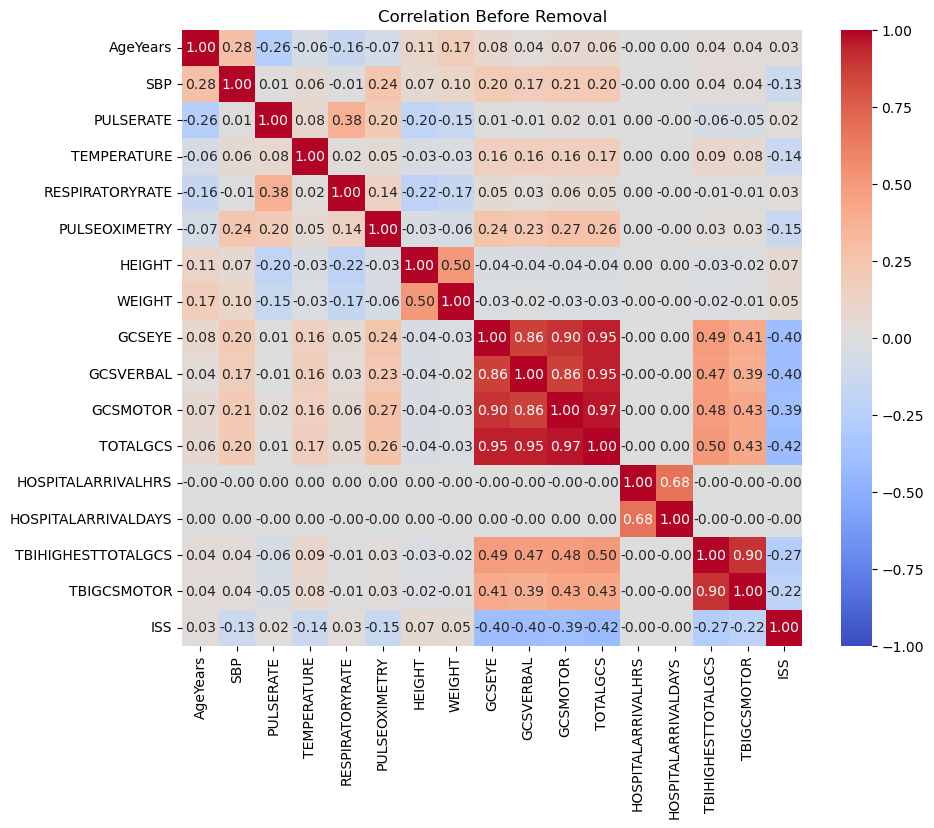

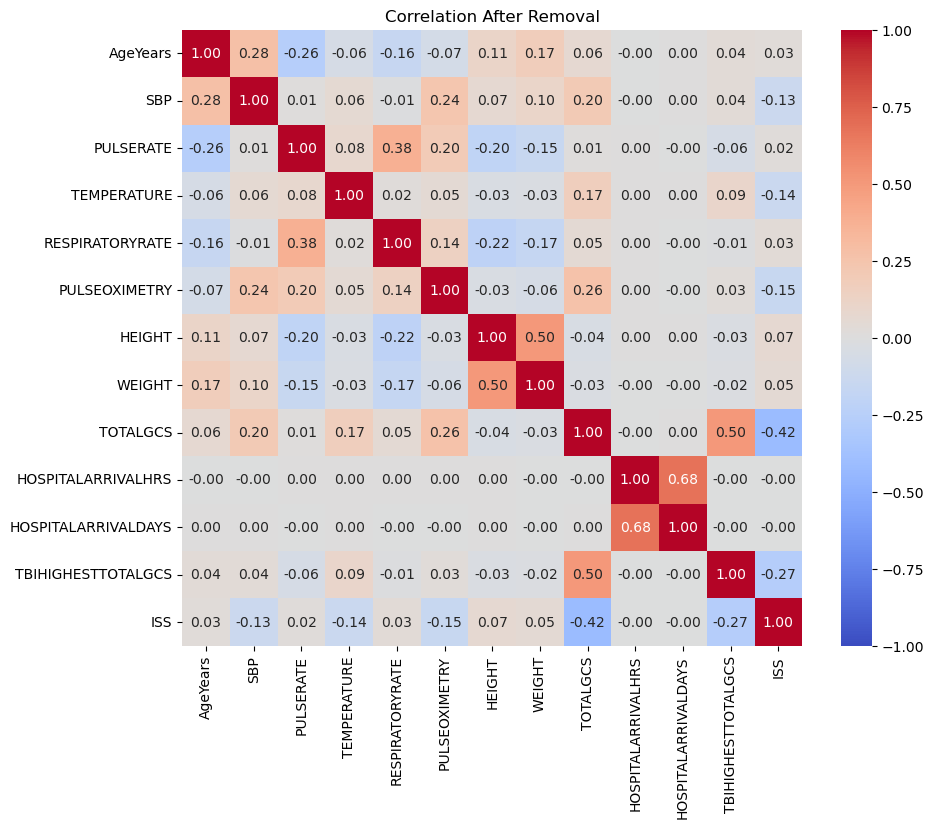

(1232956, 73)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# multicolinearity and related?
# also by the end will need to update the oh, binary, numeric, and label lists to stuff actually in the data. removed a ton after all

number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# get corr matrix
correlation_matrix = trauma_preprocessed[number_features].corr()

# Identify high correlation (above 0.9)
threshold = 0.9
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)
highly_correlated_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                           for x, y in zip(*highly_correlated) if x != y and x < y]

# Display highly correlated pairs
print("Highly correlated pairs (above 0.9 correlation):")
for pair in highly_correlated_pairs:
    print(pair)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Before Removal")
plt.show()

# Optionally: Drop one variable from each highly correlated pair
# Example of dropping 'feature2' from highly correlated pair ('feature1', 'feature2')

drop_correlated = ['GCSMOTOR','GCSEYE','GCSVERBAL','GCSMOTOR','TBIGCSMOTOR']
trauma_preprocessed = trauma_preprocessed.drop(columns=drop_correlated)

# update number_features
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]


# get corr matrix
correlation_matrix = trauma_preprocessed[number_features].corr()



# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
plt.title("Correlation After Removal")
plt.show()


trauma_preprocessed.shape

We found a high correlation above 0.7 for GCSEYE, GCSMOTOR, GCSVERBAL, and GCSTOTAL. This makes sense as the GCSTOTAL is calculated by adding the other 3 variables together, so we removed all but GCSTOTAL.

Similarly, TBIHIGHESTTOTALGCS and TBIGCSMOTOR are very much related and thus TBIGCSMOTOR can be removed.

We can continue for multicolinearity.

In [22]:
# multicolinearity for numbers:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Add constant to data for VIF calculation (intercept term)
data_with_const = add_constant(trauma_preprocessed[number_features])

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Step 3: Filter out features with high VIF (>10 for high multicollinearity)
high_vif_threshold = 10

# drop const as not in trauma_preprocesseed
i = vif_data[((vif_data.feature == 'const'))].index
vif_data = vif_data.drop(i)

features_to_drop = vif_data[vif_data["VIF"] > high_vif_threshold]["feature"].tolist()

# Step 4: Drop high VIF features from the DataFrame
trauma_preprocessed = trauma_preprocessed.drop(columns=features_to_drop)

# Display the results

print("\nFeatures with high VIF (VIF > 10):", features_to_drop)
print("\nDataFrame after dropping high VIF features:")
print(trauma_preprocessed.shape)



Features with high VIF (VIF > 10): []

DataFrame after dropping high VIF features:
(1232956, 73)


In [23]:
i = vif_data[((vif_data.feature == 'const'))].index

test = vif_data.drop(i)
vif_data

,feature,VIF
1,AgeYears,1.216293
2,SBP,1.211668
3,PULSERATE,1.291924
4,TEMPERATURE,1.047282
5,RESPIRATORYRATE,1.218881
6,PULSEOXIMETRY,1.195863
7,HEIGHT,1.391611
8,WEIGHT,1.371941
9,TOTALGCS,1.663883
10,HOSPITALARRIVALHRS,1.854661


There appears to be no issue with multicolinearity. We can then move on to encoding in the format we previously decided on, and centering and scaling.

In [24]:
# since we need the lists above for encoding, will filter to use only ones still existing:

binary_features = [col for col in binary_features if col in trauma_preprocessed.columns]
onehot_features = [col for col in onehot_features if col in trauma_preprocessed.columns]
label_features =  [col for col in label_features if col in trauma_preprocessed.columns]
number_features =  [col for col in number_features if col in trauma_preprocessed.columns]

# print(binary_features)
trauma_preprocessed.shape

(1232956, 73)

In [25]:
# encoding and scaling
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

print(trauma_preprocessed.shape)

# drop inc_key as not needed
trauma_preprocessed = trauma_preprocessed.drop(columns=['inc_key'])

preprocessor = ColumnTransformer(
    transformers=[
        # 1. One-Hot Encoding for categorical features
        ('onehot', OneHotEncoder(drop=None), onehot_features),
        
        # 2. Ordinal Encoding for binary/label features
        ('label', OrdinalEncoder(), binary_features + label_features),
        
        # 3. Standardization for continuous features
        ('scaler', StandardScaler(), number_features)
    ],
    remainder='passthrough'  # Keep any other columns in the DataFrame, if needed
)

# Fit and transform the data
processed_data = preprocessor.fit_transform(trauma_preprocessed)

# Create a DataFrame with transformed features
transformed_trauma = pd.DataFrame(processed_data, columns=preprocessor.get_feature_names_out())

# Response variable encoding
# transformed_trauma['transfusion'] = LabelEncoder().fit_transform(trauma_preprocessed['transfusion'])



print(transformed_trauma.shape)
print(transformed_trauma.columns.tolist())


(1232956, 73)
(1232956, 80)
['onehot__SEX_1.0', 'onehot__SEX_2.0', 'onehot__SEX_3.0', 'onehot__ETHNICITY_1.0', 'onehot__ETHNICITY_2.0', 'onehot__TBIMIDLINESHIFT_1.0', 'onehot__TBIMIDLINESHIFT_2.0', 'onehot__TBIMIDLINESHIFT_3.0', 'onehot__TEACHINGSTATUS_1.0', 'onehot__TEACHINGSTATUS_5.0', 'onehot__TEACHINGSTATUS_6.0', 'label__ASIAN', 'label__BLACK', 'label__ETHNICITY', 'label__RACEOTHER', 'label__WHITE', 'label__RACE_UK', 'label__WORKRELATED', 'label__PROTDEV_NONE', 'label__PROTDEV_LAP_BELT', 'label__PROTDEV_HELMET', 'label__PROTDEV_AIRBAG_PRESENT', 'label__PROTDEV_SHOULDER_BELT', 'label__PROTDEV_UK', 'label__AIRBAG_NOTDEPLOYED', 'label__AIRBAG_DEPLOYED_FRNT', 'label__AIRBAG_DEPLOYED_SIDE', 'label__AIRBAG_DEPLOYED_NA', 'label__AIRBAG_DEPLOYED_UK', 'label__TRANSPORTMODE', 'label__TM_GROUNDAMBULANCE', 'label__TM_PRIVPUBVEHWALKIN', 'label__TM_NA', 'label__TM_UK', 'label__INTERFACILITYTRANSFER', 'label__PREHOSPITALCARDIACARREST', 'label__RESPIRATORYASSISTANCE', 'label__GCSQ_SEDATEDPARALYZED

In [26]:
# # export df into a csv for ease of use in future

# # rename transfusion column for convenience
# transformed_trauma = transformed_trauma.rename(columns={'remainder__transfusion': 'transfusion'})

# # Assuming your DataFrame is named 'trauma_preprocessed_final'
# transformed_trauma.to_csv("trauma_preprocessed_final.csv", index=True)

# # Replace 'column1' and 'column2' with the actual column names
# # are_identical = transformed_trauma['remainder__transfusion'].equals(transformed_trauma['transfusion'])

# # print("Are the columns identical?", are_identical)


## Finished
Now that the data is finished and saved, we can move on to the models. The machine learning models can be found in the directory 'trauma_r' which are using R, while deep learning models can be found in the directory 'neural networks' and are using pytorch.